### In the name of God
---
### Deep Learning HW2
### Fine-tuning Resnet



**Name:** AmirMohammad Babaei

**Std. No.:** 402212399

In [1]:
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim
import matplotlib.pyplot as plt
! pip install explainable-cnn

## Data Preparation

In [2]:
# Define the transformations to apply to the images
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
batch_size = 64
num_classes = 10

########################## TODO ##########################
# Download cifar10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
####################### (5 points) #######################

########################## TODO ##########################
# Create data loaders for the train and test datasets
# In this homework we use test dataset as validation dataset

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
####################### (5 points) #######################

100%|██████████| 170498071/170498071 [00:05<00:00, 29018270.36it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Model

In [4]:
class Model(nn.Module):
    def __init__(self, num_classes, freeze=False):
        super(Model, self).__init__()

        ########################## TODO ##########################
        # Initialize a ResNet-50 torchvision model with pre-trained weights
        # Modify the last layer of the model (model.fc) and replace it with
        # a sequence of multiple linear layers according to the following structure:
        # model.fc.in_features -> 128 -> 64 -> 32 -> num_classes
        # Use Relu activation functions between linear layers and LogSoftmax at the end

        self.model = models.resnet50(pretrained=True)
        layers = [
            nn.Linear(self.model.fc.in_features, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, num_classes),
            nn.LogSoftmax(dim=1)
        ]
        # complete here
        self.model.fc = nn.Sequential(*layers)
        ####################### (20 points) ######################

        ########################## TODO ##########################
        # if freeze falg is true, freeze all model parameters except for the fc layers
        # complete here
        if freeze:
          for name, child in self.model.named_children():
              if name in ['fc']:
                  param.requires_grad = True
              for param in child.parameters():
                  param.requires_grad = False

        ####################### (5 points) #######################

    def forward(self, x):
        return self.model(x)

In [5]:
def train(model, epoch, optimizer, train_loader, criterion=nn.CrossEntropyLoss()):
    # Initialize the running loss and accuracy
    total_loss = 0
    correct = 0
    total_size = 0

    ########################## TODO ##########################
    # Set the model to train mode
    model.train()
    ####################### (5 points) #######################

    # Iterate over the batches of the train loader
    for batch_idx, (data, target) in enumerate(train_loader):
        ########################## TODO ##########################
        # Move the data and target to the device
        data = data.to(device)
        target = target.to(device)
        ####################### (5 points) #######################

        # Zero the optimizer gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        # Update the running loss
        total_loss += loss.item()
        total_size += data.size(0)

        ########################## TODO ##########################
        # Update correct variable based on model output and traget

        correct += sum(torch.argmax(output, dim=-1) == target)
        ####################### (10 points) ######################

        # Backward pass and optimizer step
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), total_loss / total_size))


    return total_loss / total_size, 100. * correct / len(train_loader.dataset)

def test(model, test_loader, criterion=nn.CrossEntropyLoss()):
    ########################## TODO ##########################
    # Set the model to evaluation mode
    model.eval()
    ####################### (5 points) #######################

    # Initialize the running loss and accuracy
    test_loss = 0
    correct = 0
    # Iterate over the batches of the validation loader
    with torch.no_grad():
        for data, target in test_loader:
            ########################## TODO ##########################
            # Move the data and target to the device
            data = data.to(device)
            target = target.to(device)
            ####################### (0 points) #######################
            # Forward pass
            output = model(data)
            loss = criterion(output, target)
            # Update the running loss and accuracy
            test_loss += loss.item()

            ########################## TODO ##########################
            # Update correct variable based on model output and traget

            correct += sum(torch.argmax(output, dim=-1) == target)
            ####################### (0 points) #######################

    # Calculate the validation loss and accuracy
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return test_loss, 100. * correct / len(test_loader.dataset)

In [6]:
model_1 = Model(num_classes, freeze=False)
model_2 = Model(num_classes, freeze=True)
model_1

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 39.2MB/s]


Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

## Training

In [7]:
########################## TODO ##########################
# Run the following code for each of the above models
# Based on your resources you can choose number of epochs from 3 to 5
####################### (10 points) #######################
model = model_1
num_epochs = 5
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001, momentum=0.9)
model = model.to(device)


####   Train Model
# Initialize variables for early stopping
early_stopping_threshold = 3
epochs_no_improve = 0
early_stop = False
best_val_acc = 0

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model, epoch, optimizer, train_loader)
    val_loss, val_acc = test(model, test_loader)

    ########################## TODO ##########################
    # Check early stopping
    if val_acc > best_val_acc:
        # complete here
        epoch_no_improve = 0
    else:
        # complete here
        epoch_no_improve += 1

    if epoch > 3 and epochs_no_improve == early_stopping_threshold:
        print('Early stopping!' )
        early_stop = True
        break

    ####################### (10 points) #######################

Train Epoch: 1 [0/50000 (0%)]	Average loss: 0.036164
Train Epoch: 1 [6400/50000 (13%)]	Average loss: 0.035970
Train Epoch: 1 [12800/50000 (26%)]	Average loss: 0.035902
Train Epoch: 1 [19200/50000 (38%)]	Average loss: 0.035791
Train Epoch: 1 [25600/50000 (51%)]	Average loss: 0.035564
Train Epoch: 1 [32000/50000 (64%)]	Average loss: 0.034978
Train Epoch: 1 [38400/50000 (77%)]	Average loss: 0.033963
Train Epoch: 1 [44800/50000 (90%)]	Average loss: 0.032907

Test set: Average loss: 0.0205, Accuracy: 5671/10000 (57%)

Train Epoch: 2 [0/50000 (0%)]	Average loss: 0.023956
Train Epoch: 2 [6400/50000 (13%)]	Average loss: 0.022284
Train Epoch: 2 [12800/50000 (26%)]	Average loss: 0.020906
Train Epoch: 2 [19200/50000 (38%)]	Average loss: 0.019664
Train Epoch: 2 [25600/50000 (51%)]	Average loss: 0.018475
Train Epoch: 2 [32000/50000 (64%)]	Average loss: 0.017452
Train Epoch: 2 [38400/50000 (77%)]	Average loss: 0.016645
Train Epoch: 2 [44800/50000 (90%)]	Average loss: 0.015919

Test set: Average loss

### GradCam

In [8]:
!wget https://benjo.ca/storage/media/31xxx/8338e0d59ef5eaa15964bd36107cd681d0b6bbef.jpeg -O cat.jpeg

--2023-11-22 21:07:38--  https://benjo.ca/storage/media/31xxx/8338e0d59ef5eaa15964bd36107cd681d0b6bbef.jpeg
Resolving benjo.ca (benjo.ca)... 104.26.2.37, 104.26.3.37, 172.67.75.131, ...
Connecting to benjo.ca (benjo.ca)|104.26.2.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3924 (3.8K) [image/jpeg]
Saving to: ‘cat.jpeg’

cat.jpeg            100%[===================>]   3.83K  --.-KB/s    in 0s      

2023-11-22 21:07:38 (30.3 MB/s) - ‘cat.jpeg’ saved [3924/3924]



In [9]:
print([n for n, _ in model_1.model.named_children()])

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']


In [10]:
!pip freeze | grep torch

torch @ https://download.pytorch.org/whl/cu118/torch-2.1.0%2Bcu118-cp310-cp310-linux_x86_64.whl#sha256=a81b554184492005543ddc32e96469f9369d778dedd195d73bda9bed407d6589
torchaudio @ https://download.pytorch.org/whl/cu118/torchaudio-2.1.0%2Bcu118-cp310-cp310-linux_x86_64.whl#sha256=cdfd0a129406155eee595f408cafbb92589652da4090d1d2040f5453d4cae71f
torchdata==0.7.0
torchsummary==1.5.1
torchtext==0.16.0
torchvision @ https://download.pytorch.org/whl/cu118/torchvision-0.16.0%2Bcu118-cp310-cp310-linux_x86_64.whl#sha256=033712f65d45afe806676c4129dfe601ad1321d9e092df62b15847c02d4061dc


In [12]:
import numpy as np
np.float = float

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


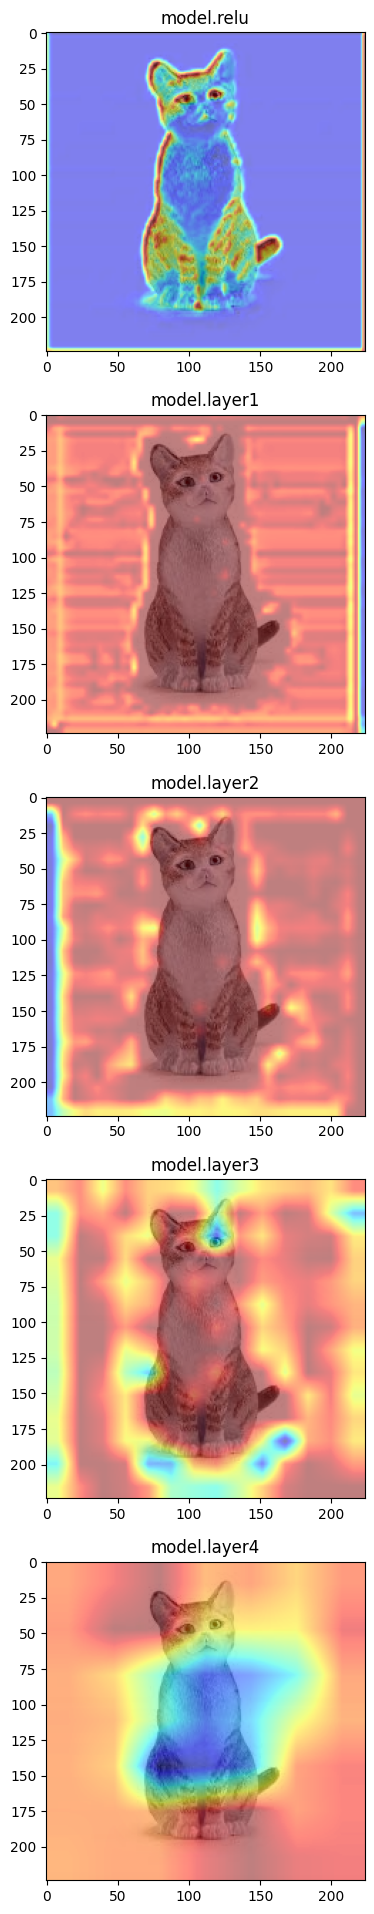

In [13]:
from explainable_cnn import CNNExplainer

classes_name = {
                0: 0, # "airplane"
                1: 1, # "automobile"
                2: 2, # "bird"
                3: 3, # "cat"
                4: 4, # "deer"
                5: 5,  # "dog"
                6: 6, # "frog"
                7: 7, # "horse"
                8: 8, # "ship"
                9: 9 # "truck"
}
layers = ["model.relu", "model.layer1", "model.layer2", "model.layer3", "model.layer4"]
x_cnn = CNNExplainer(model_1, classes_name)

########################## TODO ##########################
# Pick a picture of your choice and Run the following code with your trained model_1

grad_cam = x_cnn.get_grad_cam(
    '/content/cat.jpeg', # replace with your image path
    3, # replace with your image label
    (224, 224),
    layers,
)
####################### (5 points) #######################

fig, axs = plt.subplots(len(layers), figsize=(10, 24))
# Note that get_grad_cam() returns list of images (numpy array)
for i in range(0, len(layers)):
  axs[i].set_title(layers[i])
  axs[i].imshow(grad_cam[i].astype('uint8'))


#### Explain about one advantage and one limitation of using Grad-CAM (Gradient-weighted Class Activation Mapping) as a method for explaining the predictions of Convolutional Neural Networks (CNNs) (15 point)

One advantage of using Grad-CAM (Gradient-weighted Class Activation Mapping) as a method for explaining the predictions of Convolutional Neural Networks (CNNs) is its ability to provide visual explanations by highlighting the significant regions in an input image that contribute to the network's prediction. This makes Grad-CAM a transparent and explainable model, which is crucial for applications in fields such as medical diagnosis, where interpretability is essential[1][3].

One limitation of Grad-CAM is that it may not always provide precise localization of the important features in the input image. While it highlights the regions that correspond to the output, it does not guarantee exact localization of the features, which can limit its interpretability in certain scenarios[2].

Citations: \
[1] https://www.semanticscholar.org/paper/f4a4c51e99ca59e78024873d676fb3d4da3e0ad3 \
[2] https://www.semanticscholar.org/paper/d25f452db0fa8f39086b2e42f2d16d83ece8e1ff \
[3] https://arxiv.org/abs/2303.10401 \